In [1]:
# Import Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect, func
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
import datetime as dt

In [3]:
# Create Engine
engine = create_engine("sqlite:///hawaii.sqlite")

# Reflect Database into ORM classes
Base = automap_base()
Base.prepare(engine, reflect=True)

# Save references to the tables
Station = Base.classes.station
Measurement = Base.classes.measurement

In [4]:
# Create a session
session = Session(engine)

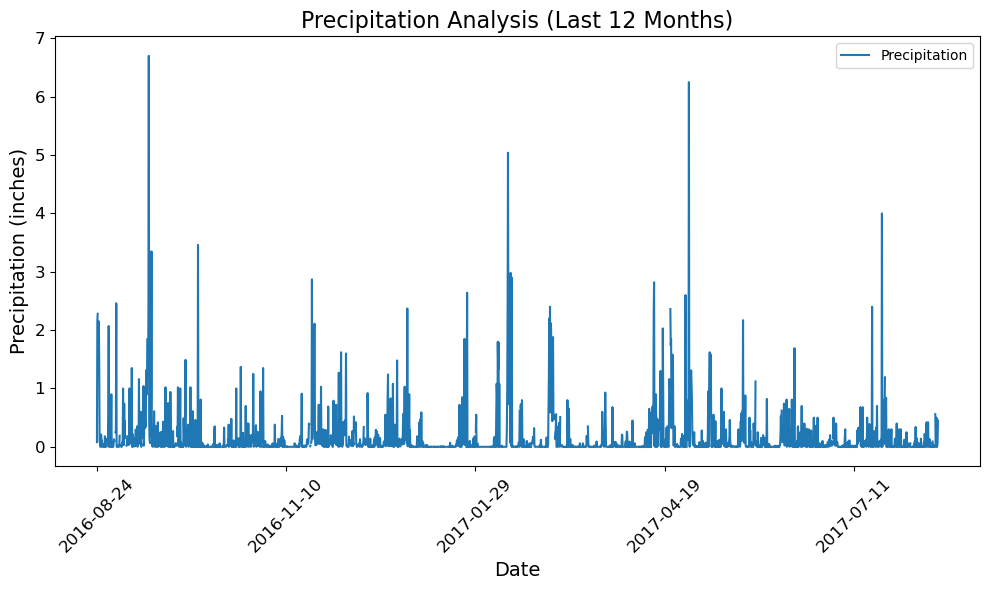

       Precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


In [5]:
# Find the most recent date in the dataset
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

# Calculate the date 1 year ago from the last data point in the database
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results to a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])
precipitation_df.set_index('Date', inplace=True)

# Sort the dataframe by date
precipitation_df.sort_index(inplace=True)

# Plot the results
precipitation_df.plot(y='Precipitation', figsize=(10, 6), legend=True, fontsize=12)
plt.title("Precipitation Analysis (Last 12 Months)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Precipitation (inches)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Use Pandas to print the summary statistics for the precipitation data
print(precipitation_df.describe())

In [6]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")

# Design a query to find the most active stations
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

# Print the most active station ID and observation count
most_active_station = most_active_stations[0][0]
most_active_observation_count = most_active_stations[0][1]
print(f"The most active station is {most_active_station} with {most_active_observation_count} observations.")

# Design a query to calculate the lowest, highest, and average temperatures for the most active station
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

# Print the temperature statistics
print(f"Temperature statistics for the most active station ({most_active_station}):")
print(f"Lowest Temperature: {temperature_stats[0][0]}")
print(f"Highest Temperature: {temperature_stats[0][1]}")
print(f"Average Temperature: {round(temperature_stats[0][2], 2)}")

Total number of stations: 9
The most active station is USC00519281 with 2772 observations.
Temperature statistics for the most active station (USC00519281):
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


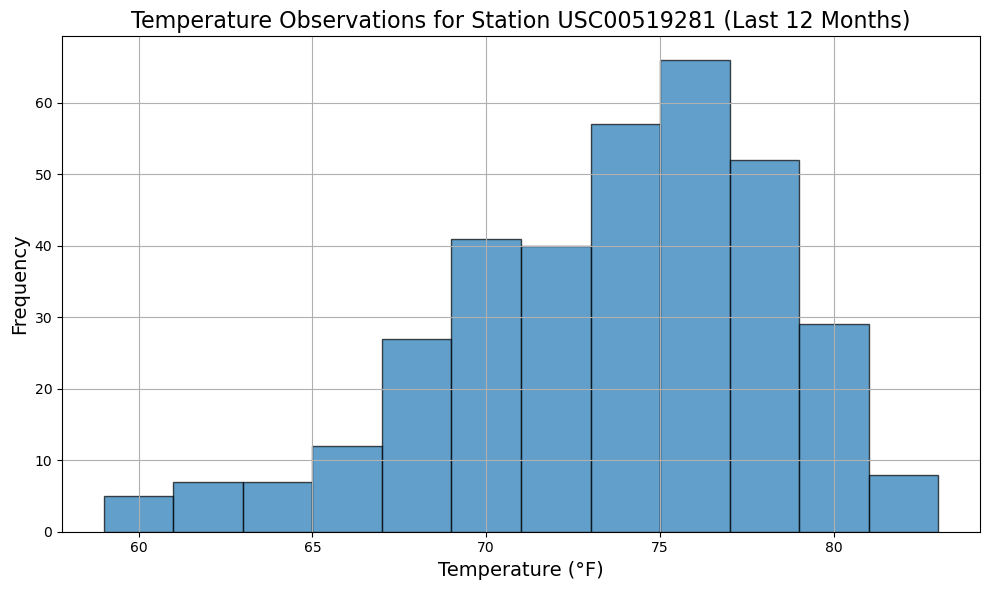

In [7]:
# Design a query to get the previous 12 months of temperature observation (TOBS) data
tobs_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results to a Pandas DataFrame
tobs_df = pd.DataFrame(tobs_data, columns=['Date', 'Temperature'])
tobs_df.set_index('Date', inplace=True)

# Plot the results as a histogram with bins=12
plt.figure(figsize=(10, 6))
plt.hist(tobs_df['Temperature'], bins=12, alpha=0.7, edgecolor='black')
plt.title(f"Temperature Observations for Station {most_active_station} (Last 12 Months)", fontsize=16)
plt.xlabel("Temperature (°F)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()